In [28]:
import os
print("Current directory:", os.getcwd())
print("Git branch:", os.popen('git branch --show-current').read().strip())

Current directory: /home/ileniag/buzi_ml4cad_noncvd
Git branch: noncvd-7y-alive


In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Requried to print df
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})
import sklearn
print(sklearn.__version__)
%matplotlib inline

1.7.2


### Filter CVD Death Patients
Remove all the NON-CVD death patients. Here we take in input the original dataset and output the original dataset with only CVD Death patients:
- Input: raw_data.xlsx, data_prelievo.xlsx, creatina_more_columns.xlsx
- Output: data_cvd.csv

In [30]:
# Load Data

df = pd.read_excel("data/raw/raw_data.xlsx",decimal=",", dtype=object)
data_prelievo = pd.read_excel("data/raw/data_prelievo.xlsx", decimal=',', dtype=object)
creatina = pd.read_excel("data/raw/creatina_more_columns.xlsx",decimal=",",dtype=object)

df = df.convert_dtypes()
data_prelievo = data_prelievo.convert_dtypes()
creatina = creatina.convert_dtypes()
df = df.drop(columns = ["Total cholesterol","HDL","LDL","Triglycerides"])
print("Filtered")

#Drop unnecessary columns


Filtered


In [31]:
# Convert date format
data_prelievo["Data prelievo"] = pd.to_datetime(data_prelievo["Data prelievo"], format="%m/%d/%Y")
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")

# Remove blank rows
df = df[df["Number"].notna()]

df_length = len(df)
df_columns_length = len(df.columns)
# Inner join
df = pd.merge(df,data_prelievo, on="Number", how="inner", suffixes=("_left","_right"))
df = pd.merge(df,creatina, on="Number", how="inner", suffixes=("_left","_right"))

print(f"DF LENGTH {df_length}, DF AFTER MERGE LENGTH {len(df)}")
# Set the Number coloumn as default index
df = df.set_index("Number")
# I've added "Data Prelievo", "Creatina", "Total cholesterol","HDL","LDL" and "Triglycerides" columns
print(df_columns_length)
print(len(df.columns))
assert df_columns_length + 5 == len(df.columns)
assert df_length == len(df)

conflicts = df[df["Data prelievo"] > df["Follow Up Data"]]
assert len(conflicts) == 0

df["Age"] = df["Age"].astype(np.int64)
#print(df)
print("Dataset size:", len(df))

DF LENGTH 8065, DF AFTER MERGE LENGTH 8065
79
84
Dataset size: 8065


In [32]:
# # Remove ONLY and ALL the deaths patients NON-CVD (Fatal MI or Sudden death, UnKnown, Accident, Suicide)
# total = df[df["Total mortality"]==1].index
# cvd_idx = df[df["CVD Death"]==1].index
# noncvd_idx = set(total) - set(cvd_idx)

# print(f"Total deaths: {len(total)}")
# print(f"Death CVD: {len(cvd_idx)}")
# print(f"Death Non-CVD: {len(noncvd_idx)}")

# df_cvd = df.drop(noncvd_idx)
# print(f"\nTotal patients: {len(df)}")
# print(f"Total patients (after removal of Death Non-CVD): {len(df_cvd)}")

# assert len(noncvd_idx) == len(total) - len(cvd_idx)
# assert len(df.columns) == len(df_cvd.columns)


# cvd_empty = 0
# non_cvd_empty = 0

# for index, row in df_cvd.iterrows():
#     if (pd.isna(row['Creatinina']) or pd.isna(row['Total cholesterol']) or pd.isna(row['HDL']) or pd.isna(row['LDL']) or pd.isna(row['Triglycerides'])) and row['Total mortality'] == 1:
#         cvd_empty +=1  
#     elif pd.isna(row['Creatinina']) or pd.isna(row['Total cholesterol']) or pd.isna(row['HDL']) or pd.isna(row['LDL']) or pd.isna(row['Triglycerides']):
#         non_cvd_empty +=1
#     #print (f"{row['Total cholesterol']} {row['HDL']} {row['LDL']} {row['Triglycerides']} {row['Creatinina']} {pd.isna(row['Creatinina'])}")

# print (cvd_empty)
# print (non_cvd_empty)
# print (f"CVD DEATHS IF WE REMOVE EMPTY VALUES: {len(cvd_idx) - cvd_empty}, NON CVD : {len(df_cvd) - non_cvd_empty - cvd_empty}")
# # Standard dataset 8.0, after removing rows with empty values 7.3
# # Filtered data set
# df_cvd.to_csv("data/raw/data_cvd.csv")

In [33]:
# Remove ONLY deaths NON-CVD within 7 years of follow-up
# Keep non-CVD deaths after 7 years (treat them as alive at 7 years)

# Calculate duration in days between data prelievo and follow-up
df['Duration_days'] = (df['Follow Up Data'] - df['Data prelievo']).dt.days
df['Duration_years'] = df['Duration_days'] / 365.25

# Identify all deaths
total = df[df["Total mortality"]==1].index
cvd_idx = df[df["CVD Death"]==1].index

# Identify non-CVD deaths
noncvd_all = set(total) - set(cvd_idx)

# Split non-CVD deaths by timing: within 7 years vs after 7 years
noncvd_within_7y = set(df[(df.index.isin(noncvd_all)) & (df['Duration_years'] <= 7)].index)
noncvd_after_7y = set(df[(df.index.isin(noncvd_all)) & (df['Duration_years'] > 7)].index)

print(f"Total deaths: {len(total)}")
print(f"Death CVD: {len(cvd_idx)}")
print(f"Death Non-CVD (total): {len(noncvd_all)}")
print(f"  - Non-CVD within 7 years (will be removed): {len(noncvd_within_7y)}")
print(f"  - Non-CVD after 7 years (will be kept as alive): {len(noncvd_after_7y)}")

# Handle the incongruent case (ID 7286 or similar)
# Check if there are cases with Total mortality=0 but Data of death present
incongruent = df[(df["Total mortality"]==0) & (df["Data of death"].notna())]
if len(incongruent) > 0:
    print(f"\nWarning: Found {len(incongruent)} incongruent record(s) with mortality=0 but death date present:")
    print(incongruent[["Data prelievo", "Follow Up Data", "Data of death", "Total mortality", "CVD Death"]])
    # These should be treated as non-CVD deaths - check if within 7 years
    for idx in incongruent.index:
        # Access Duration_years from the main dataframe
        if df.loc[idx, 'Duration_years'] <= 7:
            noncvd_within_7y.add(idx)
            print(f"  - ID {idx}: Added to removal list (non-CVD death within 7y, duration={df.loc[idx, 'Duration_years']:.2f}y)")
        else:
            noncvd_after_7y.add(idx)
            print(f"  - ID {idx}: Kept in dataset (non-CVD death after 7y, duration={df.loc[idx, 'Duration_years']:.2f}y)")

# Remove ONLY non-CVD deaths within 7 years
df_cvd = df.drop(noncvd_within_7y)

# For backward compatibility with original code
noncvd_idx = noncvd_within_7y

# For non-CVD deaths after 7 years, we keep them but should treat as "alive at 7 years"
# We'll handle this in the survival variable creation later

print(f"\nTotal patients: {len(df)}")
print(f"Total patients (after removal of Non-CVD deaths within 7y): {len(df_cvd)}")
print(f"Patients removed: {len(noncvd_idx)}")

assert len(df.columns) == len(df_cvd.columns)

# Check for empty values
cvd_empty = 0
non_cvd_empty = 0
for index, row in df_cvd.iterrows():
    if (pd.isna(row['Creatinina']) or pd.isna(row['Total cholesterol']) or 
        pd.isna(row['HDL']) or pd.isna(row['LDL']) or pd.isna(row['Triglycerides'])) and row['CVD Death'] == 1:
        cvd_empty += 1  
    elif (pd.isna(row['Creatinina']) or pd.isna(row['Total cholesterol']) or 
          pd.isna(row['HDL']) or pd.isna(row['LDL']) or pd.isna(row['Triglycerides'])):
        non_cvd_empty += 1

print(f"\nPatients with empty values:")
print(f"  - CVD deaths: {cvd_empty}")
print(f"  - Non-CVD/Alive: {non_cvd_empty}")
print(f"CVD DEATHS if we remove empty values: {len(df_cvd[df_cvd['CVD Death']==1]) - cvd_empty}")
print(f"Others (alive + non-CVD after 7y): {len(df_cvd) - non_cvd_empty - (len(df_cvd[df_cvd['CVD Death']==1]) - cvd_empty)}")

# Save filtered dataset
df_cvd.to_csv("data/raw/data_cvd.csv")

# Save also information about non-CVD deaths after 7 years for later use
noncvd_after_7y_list = list(noncvd_after_7y)
print(f"\nNon-CVD deaths after 7 years (kept in dataset): {len(noncvd_after_7y_list)}")
if len(noncvd_after_7y_list) > 0:
    with open("data/raw/noncvd_after_7y.txt", "w") as f:
        f.write(",".join(map(str, noncvd_after_7y_list)))

Total deaths: 2406
Death CVD: 1008
Death Non-CVD (total): 1398
  - Non-CVD within 7 years (will be removed): 1046
  - Non-CVD after 7 years (will be kept as alive): 352

       Data prelievo Follow Up Data Data of death  Total mortality  CVD Death
Number                                                                       
7286      2009-11-29     2012-10-11    2012-10-11                0          0
  - ID 7286: Added to removal list (non-CVD death within 7y, duration=2.87y)

Total patients: 8065
Total patients (after removal of Non-CVD deaths within 7y): 7018
Patients removed: 1047

Patients with empty values:
  - CVD deaths: 177
  - Non-CVD/Alive: 498
CVD DEATHS if we remove empty values: 831
Others (alive + non-CVD after 7y): 5689

Non-CVD deaths after 7 years (kept in dataset): 352


### Clean Irrelevant Features
From the only CVD death patients, we remove all the irrelevant features for the classification task. We also create a target feature. 
- Input: data_cvd.csv
- Output: 18features/data, 27features/data, 23features/data, 32features/data.

These datasets contain, respectively: the first one includes every column except Total cholesterol, HDL, LDL, Triglycerides, Creatinine, and the Thyroid columns; the second one contains the Thyroid columns in addition, but excludes the Total cholesterol, HDL, LDL, Triglycerides, and Creatinine columns; the third one includes Total cholesterol, HDL, LDL, Triglycerides, and Creatinine, but not the Thyroid columns; and the last one includes all columns

In [34]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])

Text(0, 0.5, 'Patients')

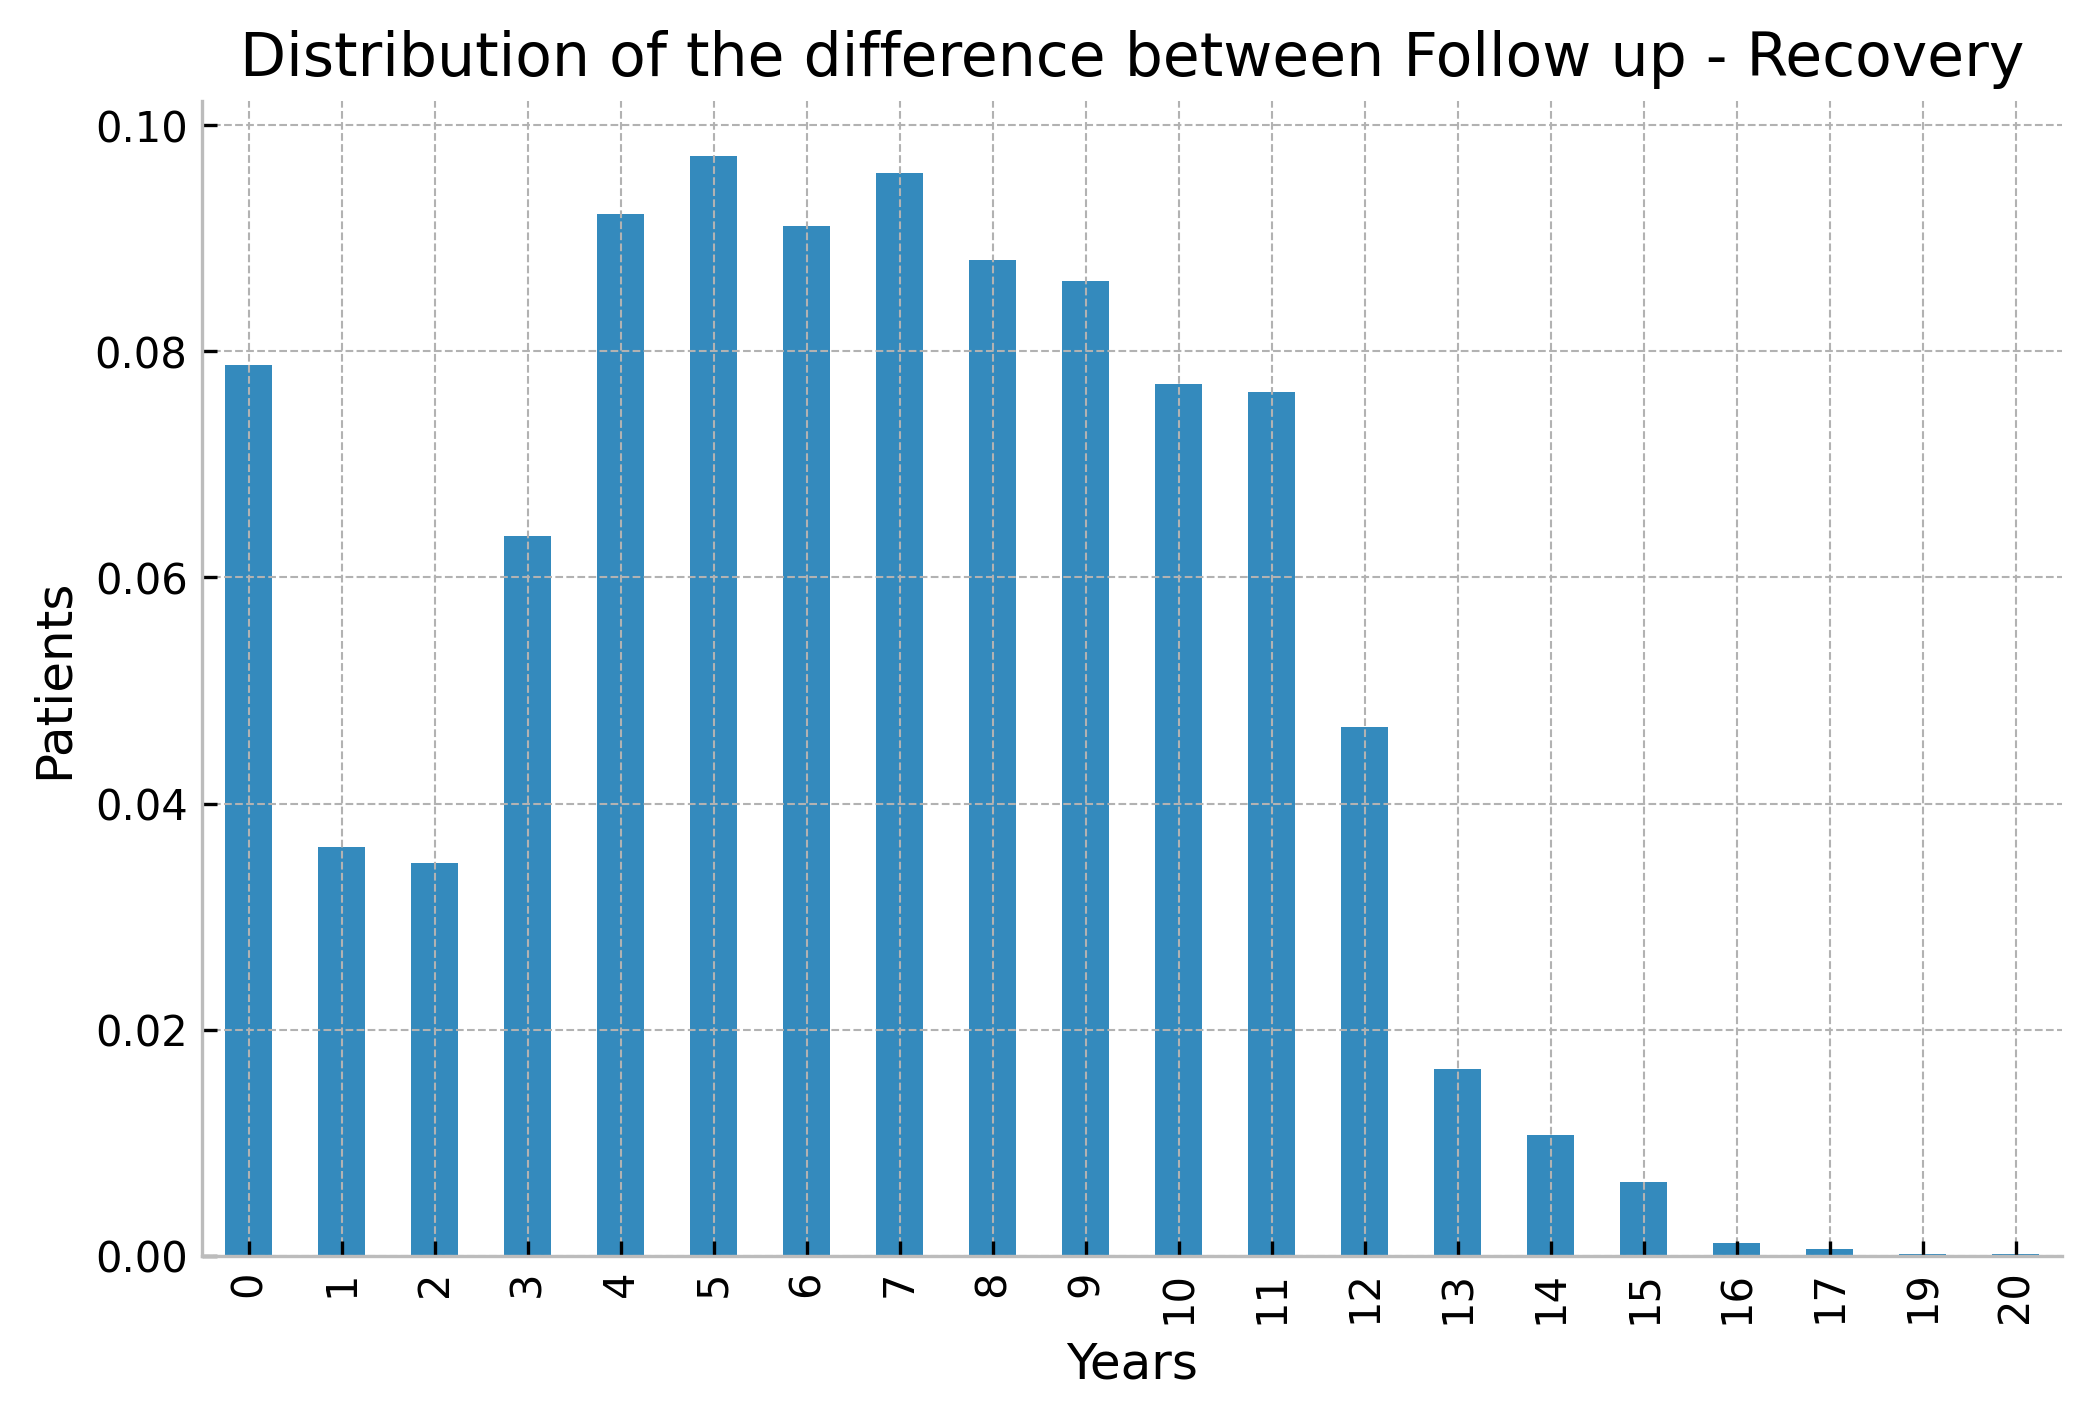

In [35]:
# Compute difference between dates: follow up and admission
figure = plt.figure()
df_diff = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_diff.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(8,5), ax=plt.gca())
plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Patients")

In [36]:
from sklearn.model_selection import train_test_split
# Clean features remove follow up features
df_feat = df_cvd.copy()

# Remove columns that were not found within the old dataset
to_drop = ['Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

df_feat = df_feat.drop(columns= to_drop)

# Thyroid related columns, 9 columns.
thyroid_columns = ["TSH","fT3","fT4","Euthyroid","Subclinical primary hypothyroidism (SCH)","Subclinical primary hyperthyroidism\n(SCT)","Low T3","Ipotiroidismo","Ipertiroidismo"]

#Columns with missing values
drop_columns_missing = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina']

# Not useful columns
df_feat = df_feat.drop(columns=["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"])

# Remove duration columns added during preprocessing
if 'Duration_days' in df_feat.columns:
    df_feat = df_feat.drop(columns=['Duration_days', 'Duration_years'])

    
# Create and add target feature `Survive`
years = 7
survive = (df_diff < years) & df_cvd["CVD Death"]
survive = (survive + 1) % 2
df_feat[f"Survive{years}Y"] = survive

# Used for mean solutions
df_train, df_test = train_test_split(df_feat.copy(), test_size=0.2, stratify=df_feat.copy().iloc[:,-1])
df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train.iloc[:,-1])

# We handle missing value by removing those rows which have empty values and with filling empty values with the mean value 
dropped_na = df_feat.dropna()
mean_value = df_train.mean(numeric_only=True)

mean_imputation = df_train.fillna(mean_value.round(2))
# Generate datasets for models with different number of parameters 
_23df = dropped_na.copy().drop(columns = thyroid_columns) 
_23df_mean = mean_imputation.copy().drop(columns = thyroid_columns)
# Valid and Test set for mean 
_23df_valid = df_valid.copy().drop(columns = thyroid_columns).dropna()
_23df_test = df_test.copy().drop(columns = thyroid_columns).dropna()

_27df = df_feat.copy().drop(columns = drop_columns_missing)
_18df = _27df.copy().drop(columns = thyroid_columns)

_32df = dropped_na.copy()
_32df_mean = mean_imputation.copy()
# Valid and Test set for mean
_32df_valid = df_valid.copy().dropna()
_32df_test = df_test.copy().dropna()

# Datasets with missing values handled

print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))

_23df = _23df.convert_dtypes()
_27df = _27df.convert_dtypes()
_18df = _18df.convert_dtypes()
_32df = _32df.convert_dtypes()

print(len(_23df.columns),len(_27df.columns),len(_18df.columns),len(_32df.columns) )
assert len(_27df.columns) == 27
assert len(_18df.columns) == 18
assert len(_23df.columns) == 23
assert len(_32df.columns) == 32

_18df.to_csv("data/18features/data.csv")
_27df.to_csv("data/27features/data.csv")
_23df.to_csv("data/23features/dropped_na/data.csv")
_32df.to_csv("data/32features/dropped_na/data.csv")

# Mean related
_23df_concat = pd.concat([_23df_mean, _23df_valid, _23df_test], axis=0)
_23df_concat.to_csv("data/23features/mean/data.csv")
_23df_mean.to_csv("data/23features/mean/train.csv")
_23df_valid.to_csv("data/23features/mean/valid.csv")
_23df_test.to_csv("data/23features/mean/test.csv")


_32df_concat = pd.concat([_32df_mean, _32df_valid, _32df_test], axis=0)
_32df_concat.to_csv("data/32features/mean/data.csv")
_32df_mean.to_csv("data/32features/mean/train.csv")
_32df_valid.to_csv("data/32features/mean/valid.csv")
_32df_test.to_csv("data/32features/mean/test.csv")

Total patient: 	 7018
Survived: 	 6175 	 0.8798803077799943
Dead: 		 843 	 0.1201196922200057
23 27 18 32


### Extra
Create and save the subset datagroups

In [37]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

split_and_save(_18df, "data/18features/")
split_and_save(_27df, "data/27features/")
split_and_save(_23df, "data/23features/dropped_na/")
split_and_save(_32df, "data/32features/dropped_na/")


Train: 	 4210
Valid: 	 1404
Test: 	 1404
Train: 	 4210
Valid: 	 1404
Test: 	 1404
Train: 	 3805
Valid: 	 1269
Test: 	 1269
Train: 	 3805
Valid: 	 1269
Test: 	 1269


In [38]:
from collections import Counter

df_train = pd.read_csv("./data/27features/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/27features/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/27features/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))
print("####################")
df_train = pd.read_csv("./data/18features/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/18features/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/18features/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))
print("####################")
df_train = pd.read_csv("./data/23features/dropped_na/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/23features/dropped_na/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/23features/dropped_na/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))
print("####################")
df_train = pd.read_csv("./data/32features/dropped_na/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/32features/dropped_na/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/32features/dropped_na/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))
print("####################")
df_train = pd.read_csv("./data/23features/mean/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/23features/mean/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/23features/mean/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))
print("####################")
df_train = pd.read_csv("./data/32features/mean/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/32features/mean/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/32features/mean/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))


Counter({1: 3705, 0: 505})
Counter({1: 1235, 0: 169})
Counter({1: 1235, 0: 169})
####################
Counter({1: 3705, 0: 505})
Counter({1: 1235, 0: 169})
Counter({1: 1235, 0: 169})
####################
Counter({1: 3378, 0: 427})
Counter({1: 1126, 0: 143})
Counter({1: 1127, 0: 142})
####################
Counter({1: 3378, 0: 427})
Counter({1: 1126, 0: 143})
Counter({1: 1127, 0: 142})
####################
Counter({1: 3705, 0: 505})
Counter({1: 1129, 0: 140})
Counter({1: 1119, 0: 144})
####################
Counter({1: 3705, 0: 505})
Counter({1: 1129, 0: 140})
Counter({1: 1119, 0: 144})


In [39]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)


<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_noncvd/exported_notebooks/1_data_process_20251027_190438.html
